In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip


In [2]:
import pandas as pd
df_train = pd.read_csv('/kaggle/input/tgs-salt-identification-challenge/train.csv')

In [3]:
df_train

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
...,...,...
3995,9cbd5ddba4,NaN
3996,caa039b231,2398 7 2499 11 2600 16 2700 22 2801 26 2901 29...
3997,1306fcee4c,NaN
3998,48d81e93d9,2828 1 2927 3 3026 5 3126 6 3225 8 3324 10 342...


In [4]:
df_depth= pd.read_csv('/kaggle/input/tgs-salt-identification-challenge/depths.csv')

In [5]:
df_depth

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783
...,...,...
21995,09f1675cfb,400
21996,6947dbc4f4,804
21997,68de95fb39,605
21998,fdad2f99d8,309


In [6]:
df = pd.merge(df_depth, df_train)
df['salt'] = df['rle_mask'].notnull().replace([False, True], [0,1]) #0 = no_salt #1 = salt
df.head()

,id,z,rle_mask,salt
0,4ac19fb269,306,5757 1 5851 8 5936 24 6034 27 6134 28 6224 39 ...,1
1,1825fadf99,157,NaN,0
2,f59821d067,305,36 66 137 66 239 65 340 65 442 64 543 64 644 6...,1
3,5b435fad9d,503,7474 1 7574 2 7674 3 7774 4 7874 5 7974 6 8074...,1
4,e340e7bfca,783,NaN,0


In [7]:
import zipfile
import os

# Replace 'competition_data.zip' with the actual name of your zip file
with zipfile.ZipFile('/kaggle/input/tgs-salt-identification-challenge/competition_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [8]:
import glob
import os

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as K
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
import cv2
import numpy as np

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard


In [12]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [14]:
smooth = 1e-15

In [15]:
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    iou_score = jac  # You might want to assign jac to iou_score if that's what you intended
    return jac, iou_score

In [16]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [17]:
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [19]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = "/kaggle/working/competition_data/train/images"

# Output folder for resized images
output_folder = "/kaggle/working/train_images"
os.makedirs(output_folder, exist_ok=True)

# Target size
target_size = (256, 256)

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Process each image
for image_file in image_files:
    # Read the image
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    
    # Resize the image
    resized_img = img.resize(target_size, Image.ANTIALIAS)
    
    # Save the resized image
    output_path = os.path.join(output_folder, image_file)
    resized_img.save(output_path)

print("Resizing complete.")


/tmp/ipykernel_42/1218345760.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Resizing complete.


In [20]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = "/kaggle/working/competition_data/train/masks"

# Output folder for resized images
output_folder = "/kaggle/working/train_masks"
os.makedirs(output_folder, exist_ok=True)

# Target size
target_size = (256, 256)

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Process each image
for image_file in image_files:
    # Read the image
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    
    # Resize the image
    resized_img = img.resize(target_size, Image.ANTIALIAS)
    
    # Save the resized image
    output_path = os.path.join(output_folder, image_file)
    resized_img.save(output_path)

print("Resizing complete.")



/tmp/ipykernel_42/2560810055.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Resizing complete.


In [21]:
from tensorflow.keras.layers import AveragePooling2D, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate

def ASPP(inputs):
    shape = inputs.shape

    # Global average pooling
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name='bn_1')(y_pool)
    y_pool = Activation('relu', name='relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    # Atrous convolutions with different rates
    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    # Concatenate features from different branches
    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    # Final convolution
    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    return y


In [22]:
# Import necessary libraries
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model




In [23]:
# Assuming you want to include the entire code in a single cell
import os

H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [24]:
from glob import glob
from sklearn.model_selection import train_test_split
import os

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "train_images", "*.png")))
    masks = sorted(glob(os.path.join(path, "train_masks", "*.png")))
    
    split_size = int(len(images) * split)
    print(split_size)
    
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
    
    train_x, test_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=split_size, random_state=42)
    
    return (train_x, train_y), (test_x, test_y), (valid_x, valid_y)


In [25]:
def read_image(path):
    path = path.decode()  # Decode the path if it's in bytes
    x = cv2.imread(path, cv2.IMREAD_COLOR)  # Read the image in color
    x = cv2.resize(x, (W, H))  # Resize the image to the specified dimensions
    x = x / 255.  # Normalize pixel values to the range [0, 1]
    x = x.astype(np.float32)  # Convert the image to float32
    return x

In [26]:
# Cell 1: Import necessary libraries and define constants
import cv2
import numpy as np
import tensorflow as tf


# Cell 2: Define the read_mask function
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # (h, w)
    x = cv2.resize(x, (W, H))  # (h, w) ## (h, w)
    x = x / 255.
    x = x.astype(np.float32)  # (h, w)
    x = np.expand_dims(x, axis=-1)  # (h, w, 1)
    return x

# Cell 3: Define the tf_parse function
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

# Cell 4: Define the tf_dataset function
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [27]:
if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir("files")

    batch_size = 8
    lr = 1e-4
    num_epochs = 50
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    dataset_path = "/kaggle/working/"

    (train_x, train_y), (test_x, test_y), (valid_x, valid_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]

    model = DeepLabV3Plus((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou])

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

    # Evaluate the model on the validation dataset
    loss, dice_coef_val, iou_val = model.evaluate(valid_dataset)
    print(f'Validation Dice Coefficient: {dice_coef_val}, Validation IOU: {iou_val}')


800
Train: 3200 - 3200
Test : 800 - 800
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
400/400 [==============================] - 111s 163ms/step - loss: 0.2551 - dice_coef: 0.7449 - iou: 0.6231 - val_loss: 0.8641 - val_dice_coef: 0.1359 - val_iou: 0.0750 - lr: 1.0000e-04
Epoch 2/50
400/400 [==============================] - 64s 160ms/step - loss: 0.1793 - dice_coef: 0.8207 - iou: 0.7228 - val_loss: 0.4647 - val_dice_coef: 0.5353 - val_iou: 0.3869 - lr: 1.0000e-04
Epoch 3/50
400/400 [==============================] - 64s 160ms/step - loss: 0.1563 - dice_coef: 0.8437 - iou: 0.7534 - val_loss: 0.7271 - val_dice_coef: 0.2729 - val_iou: 0.1823 - lr: 1.0000e-04
Epoch 4/50
400/400 [==============================] - 64s 160ms/step - loss: 0.1366 - dice_coef: 0.8634 - iou: 0.7803 - val_loss: 0.5763 - val_dice_coef: 0.4237 - val_iou: 0.3043 - lr: 1.0000e-04
Epoch 5/50
400/400 [==============================] - 64s 160ms/step - loss: 0.1130 - dice_coef: 0.8870 - iou:

In [28]:
evaluation_results = model.evaluate(valid_dataset)
print("Evaluation Results:", evaluation_results)

100/100 [==============================] - 4s 43ms/step - loss: 0.0989 - dice_coef: 0.9011 - iou: 0.8407
Evaluation Results: [0.0989019125699997, 0.9010978937149048, 0.8407453894615173]


In [31]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming 'model' is your trained segmentation model
# Make sure the model is loaded with the correct architecture and weights

# Load a single test image
test_image_path = '/kaggle/working/competition_data/test/images/0cf880cdf5.png'
test_image = image.load_img(test_image_path, target_size=(H,W))  # Set the target size based on your model's input size
test_image_array = image.img_to_array(test_image)
test_image_array /= 255.0 
threshold = 0.5
test_image_array = np.expand_dims(test_image_array, axis=0)

predicted_mask = model.predict(test_image_array)

binary_mask = (predicted_mask > threshold).astype(np.uint8)



1/1 [==============================] - 0s 23ms/step


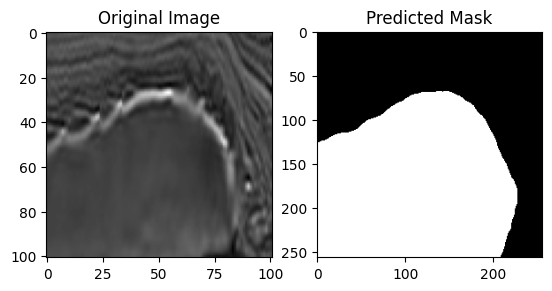

In [32]:
# Visualize the original image and predicted mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(test_image_path))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')  # Assuming your model outputs a single-channel mask
plt.title("Predicted Mask")

plt.show()

In [33]:
model.save('/kaggle/working/files/model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from IPython.display import FileLink

# Specify the path to the model.h5 file
model_path = '/kaggle/working/files/model.h5'

# Create a download link
FileLink(model_path)


/kaggle/working/files/model.h5

In [35]:
import h5py

# Specify the path to the model.h5 file
model_path = '/kaggle/working/files/model.h5'

# Open the HDF5 file
with h5py.File(model_path, 'r') as file:
    # Print the keys at the top level of the HDF5 file
    print("Top-level keys in the HDF5 file:")
    print(list(file.keys()))
    
    # Optionally, explore specific groups or datasets within the file
    if 'model_weights' in file:
        print("\nKeys in the 'model_weights' group:")
        print(list(file['model_weights'].keys()))

    # You can continue exploring the structure of the HDF5 file based on your needs


Top-level keys in the HDF5 file:
['model_weights', 'optimizer_weights']

Keys in the 'model_weights' group:
['activation', 'activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'average_pooling', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6', 'batch_normalization_7', 'bn_1', 'concatenate', 'concatenate_1', 'conv1_bn', 'conv1_conv', 'conv1_pad', 'conv1_relu', 'conv2_block1_0_bn', 'conv2_block1_0_conv', 'conv2_block1_1_bn', 'conv2_block1_1_conv', 'conv2_block1_1_relu', 'conv2_block1_2_bn', 'conv2_block1_2_conv', 'conv2_block1_2_relu', 'conv2_block1_3_bn', 'conv2_block1_3_conv', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_bn', 'conv2_block2_1_conv', 'conv2_block2_1_relu', 'conv2_block2_2_bn', 'conv2_block2_2_conv', 'conv2_block2_2_relu', 'conv2_block2_3_bn', 'conv2_block2_3_conv',

1/1 [==============================] - 0s 24ms/step


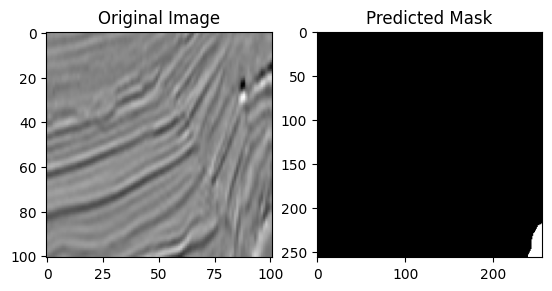

1/1 [==============================] - 0s 24ms/step


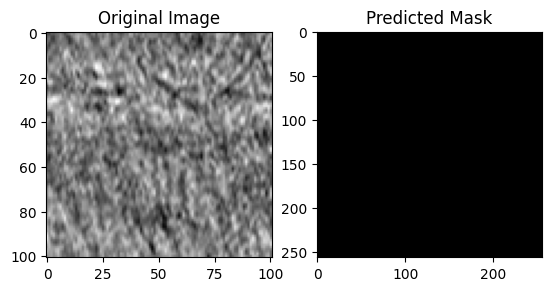

1/1 [==============================] - 0s 23ms/step


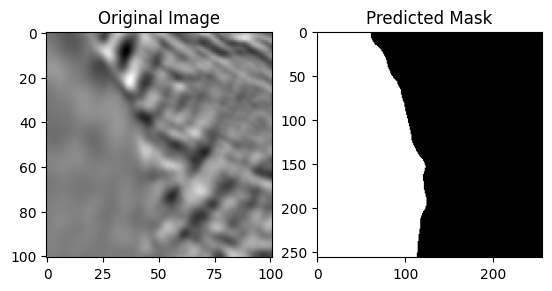

1/1 [==============================] - 0s 24ms/step


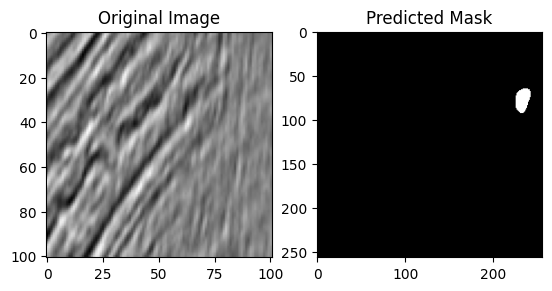

1/1 [==============================] - 0s 23ms/step


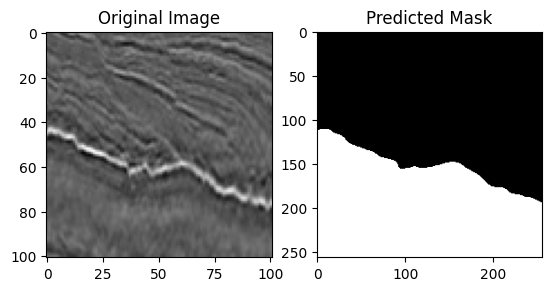

1/1 [==============================] - 0s 24ms/step


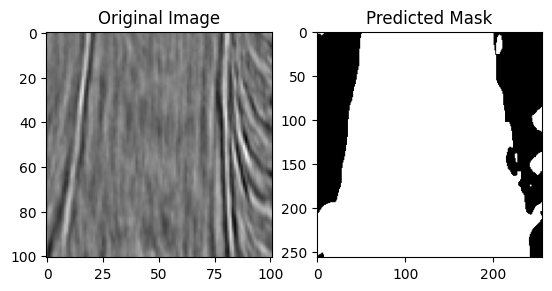

1/1 [==============================] - 0s 24ms/step


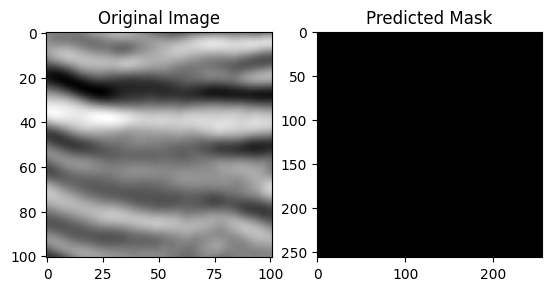

1/1 [==============================] - 0s 23ms/step


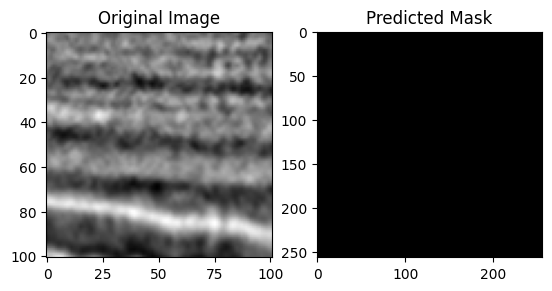

1/1 [==============================] - 0s 23ms/step


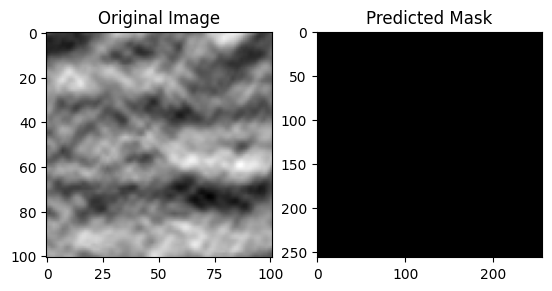

1/1 [==============================] - 0s 23ms/step


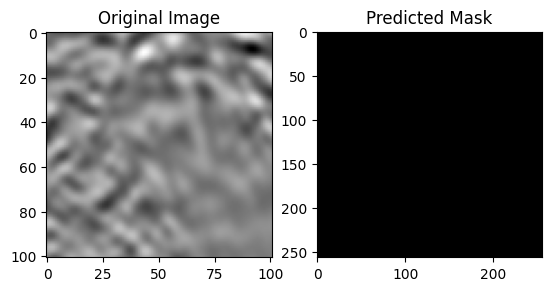

1/1 [==============================] - 0s 23ms/step


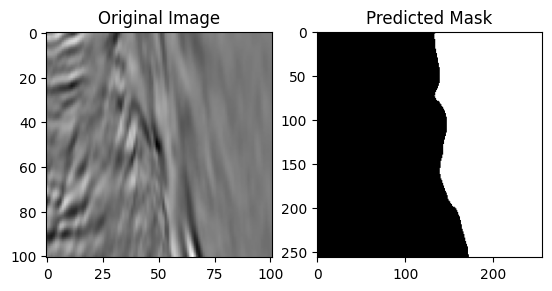

1/1 [==============================] - 0s 23ms/step


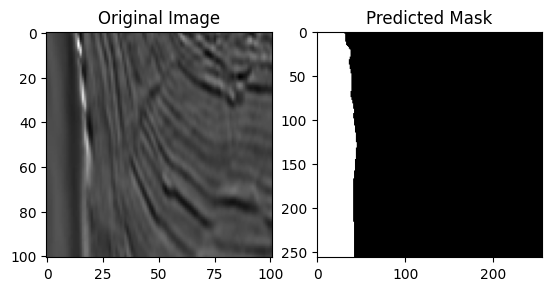

1/1 [==============================] - 0s 24ms/step


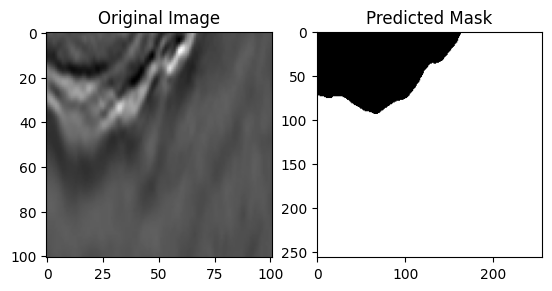

1/1 [==============================] - 0s 23ms/step


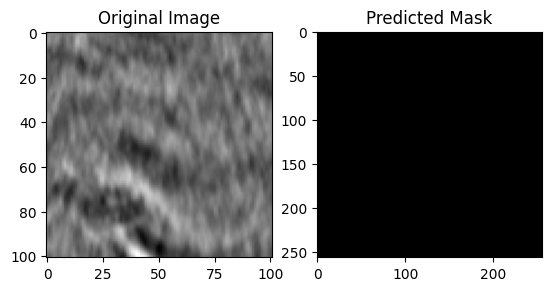

1/1 [==============================] - 0s 23ms/step


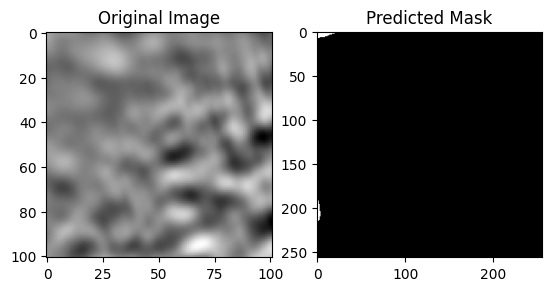

1/1 [==============================] - 0s 23ms/step


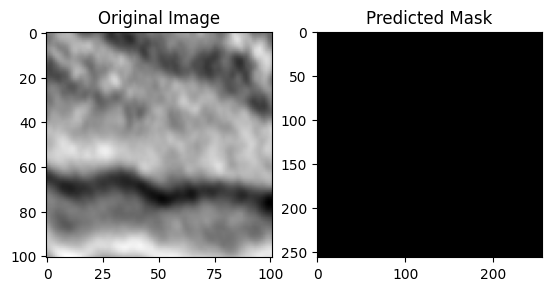

1/1 [==============================] - 0s 22ms/step


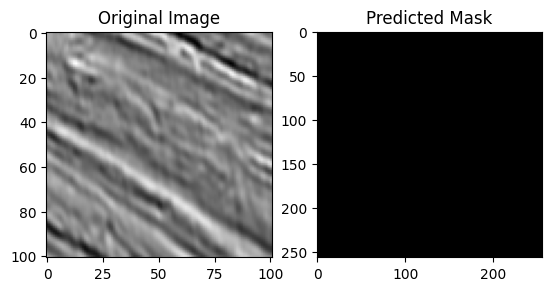

1/1 [==============================] - 0s 23ms/step


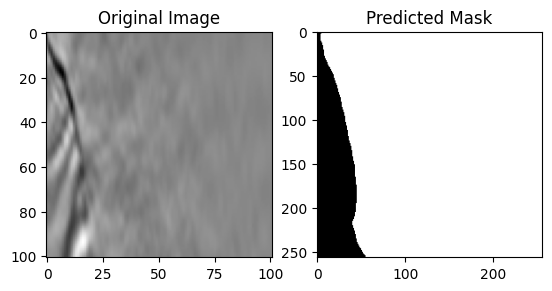

1/1 [==============================] - 0s 24ms/step


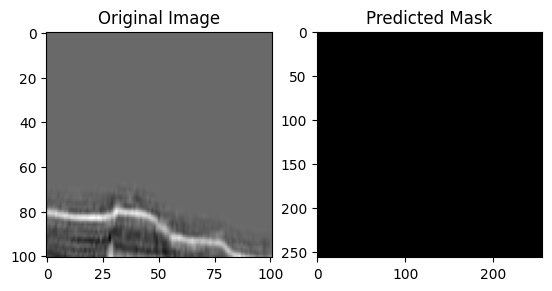

1/1 [==============================] - 0s 23ms/step


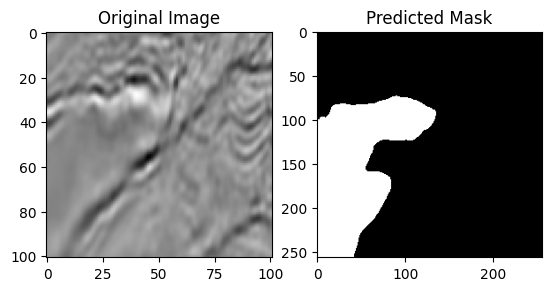

In [40]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import random

# Assuming 'model' is your trained segmentation model
# Make sure the model is loaded with the correct architecture and weights

# Path to the directory containing test images
test_images_dir = '/kaggle/working/competition_data/test/images/'

# List all files in the test images directory
all_image_files = os.listdir(test_images_dir)

# Randomly select 20 images
random_images = random.sample(all_image_files, 20)

# Set the target size based on your model's input size
H, W = (256, 256)

# Load and predict masks for each random image
for image_file in random_images:
    # Construct the full path to the image
    test_image_path = os.path.join(test_images_dir, image_file)

    # Load the test image
    test_image = image.load_img(test_image_path, target_size=(H, W))
    test_image_array = image.img_to_array(test_image)
    test_image_array /= 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)

    # Predict the mask
    predicted_mask = model.predict(test_image_array)

    # Binary mask threshold
    threshold = 0.5
    binary_mask = (predicted_mask > threshold).astype(np.uint8)

    # Visualize the original image and predicted mask
    import matplotlib.pyplot as plt

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(test_image_path))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask[0, :, :, 0], cmap='gray')  # Assuming your model outputs a single-channel mask
    plt.title("Predicted Mask")

    plt.show()